Combustion Engines identification using Machine Learning techniques

USP Esalq - MBA Data Science & Analytics - 2022/2

Matheus Felipe Sozza

# 1. Libraries Installing and Importing

## 1.1. Install and Import libraries

In [1]:
#pip install librosa numpy pandas matplotlib scipy sklearn IPython mir_eval dill

In [2]:
# Import modules
%matplotlib inline
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
import scipy.signal
import math
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Custom library created for the project
import soundDetection_AuxiliarFunctions

## 1.2. Import **Audio** files and **Metadata** from file system

In [47]:
# Path related variables
PROJECT_PATH = 'C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/'
METADATA_FILE = PROJECT_PATH + 'DatasetMapping.csv'
AUDIOS_PATH = PROJECT_PATH + 'UrbanSounds8k'

# Audio processing variables
AUDIO_SR = 44100 # Audio sampling in Hertz
AUDIO_N_FFT = 2048 # Samples per FFT window

# Audio segmentation variables
AUDIOSEG_SIZE = 22050 # samples per segment (500ms)
AUDIOSEG_OVERLAP = 0.5 # normalized

# 2. **Audios Dataset** creation (Pandas)

In [4]:
from soundDetection_AuxiliarFunctions import createAudiosDataset
audios_DF = soundDetection_AuxiliarFunctions.createAudiosDataset(METADATA_FILE, AUDIOS_PATH)

C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/100032-3-0-0.wav  ---> Index:  0
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/122690-6-0-0.wav  ---> Index:  1000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/147926-0-0-44.wav  ---> Index:  2000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/162434-6-2-0.wav  ---> Index:  3000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/178260-7-1-9.wav  ---> Index:  4000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/195969-0-0-19.wav  ---> Index:  5000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/30204-0-0-11.wav  ---> Index:  6000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/60605-9-0-90.wav  ---> Index:  7000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/77751-4-9-1.wav  ---> Index:  8000
Number of processed audio files: 8732


In [5]:
#  Label if it is an engine sound
audios_DF['isEngine'] = audios_DF['class'].map({'engine_idling': 1, 'air_conditioner':0, 'car_horn':0,
                                       'children_playing':0, 'dog_bark':0, 'drilling':0, 'gun_shot':0,
                                       'jackhammer':0, 'siren':0, 'street_music':0}, na_action=None)

audios_DF.head()

,filename,duration,class,isEngine
0,100032-3-0-0.wav,0.317551,dog_bark,0
1,100263-2-0-117.wav,4.000000,children_playing,0
2,100263-2-0-121.wav,4.000000,children_playing,0
3,100263-2-0-126.wav,4.000000,children_playing,0
4,100263-2-0-137.wav,4.000000,children_playing,0


In [6]:
# Audios histogram per type
#audios_DF['isEngine'].plot.hist(bins=12, alpha=0.5)

In [7]:
# Audios histogram per duration
#audios_DF['duration'].plot.hist(bins=12, alpha=0.5,)
#audios_DF.plot.hist(column=["duration"],by="class", bins=4, alpha=1, figsize=(10, 25),)

# 3. Process the sound files and extract spectogram

## 3.1. Process and get spectogram

Text(0, 0.5, 'Signal')

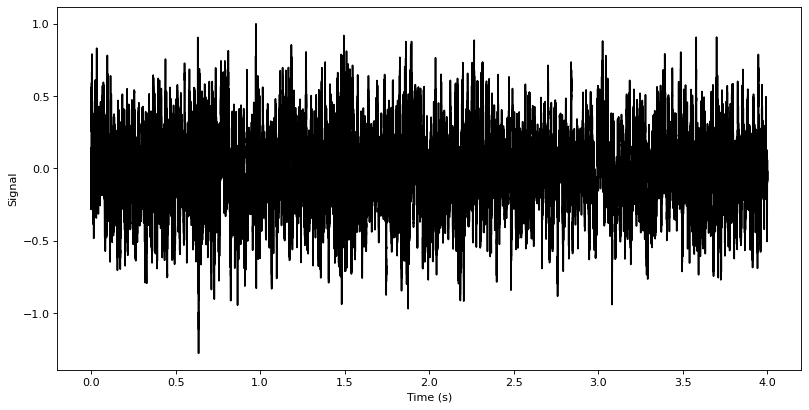

In [14]:
audioArray, spectMatrix = soundDetection_AuxiliarFunctions.extractSpectogram(AUDIOS_PATH + '/100263-2-0-161.wav', arg_nfft=2048,arg_hoplen=512,arg_nmels=26, sr = AUDIO_SR)

audioArray_time = np.arange(len(audioArray))/AUDIO_SR

# Plot Audio signal
figure(figsize=(12,6), dpi=80)
plt.plot(audioArray_time, audioArray, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

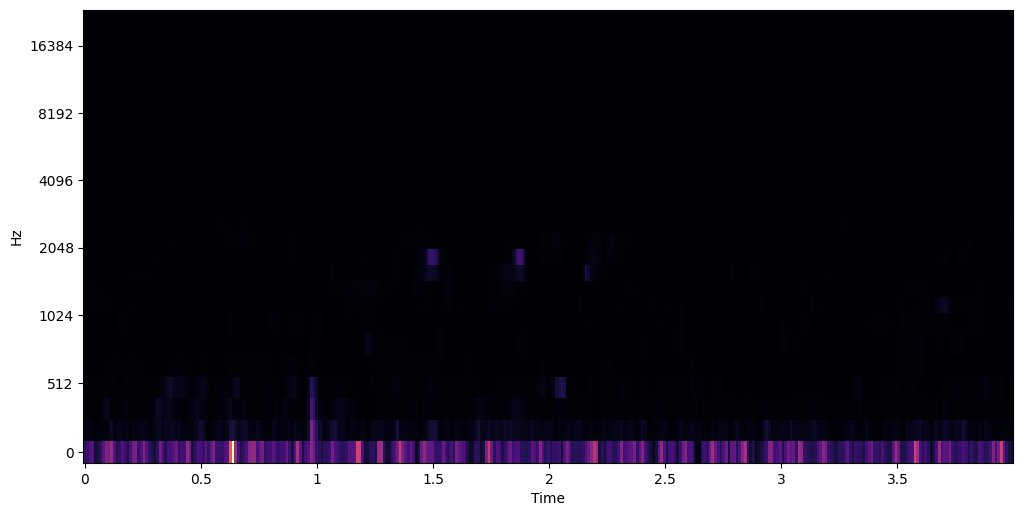

In [15]:
# Plot Mel Spectogram
figure(figsize=(12,6), dpi=100)
img = librosa.display.specshow(spectMatrix, x_axis='time',y_axis='mel', sr=44100)

In [ ]:
Audio(AUDIOS_PATH + '/100263-2-0-161.wav',rate=44100)

AttributeError: module 'numpy' has no attribute 'range'

In [57]:
# Compile all audios in an array of Spectogram Matrices
audio_AA = [] # Audio "array of arrays" (AA) - all audios in one object
spectogram_AM = [] # Spectogram "Array of Matrices" (AM) - all spectogram in one object

# Append all the spectograms matrices in a single array
for idx, rowData in audios_DF.iterrows():
    if(idx%1000 == 0): #Feedback
        print(idx)

    audioMatrix, spectMatrix = soundDetection_AuxiliarFunctions.extractSpectogram(AUDIOS_PATH + '/' + rowData['filename'], arg_nfft=2048,arg_hoplen=512,arg_nmels=26, sr = AUDIO_SR)
    spectogram_AM.append(spectMatrix) 
    audio_AA.append(audioMatrix) 

    if idx == 2: # DELETE AFTER - JUST FOR QUICK TESTING
        break

0


## 3.2. Create segmented subset

In [69]:
audio_AA[0][0:5]

array([-0.00454726, -0.00483718, -0.00460829, -0.00468459, -0.00488296],
      dtype=float32)

In [75]:

subAudio_AA = [] ## Subsegmented Audio "array of arrays" (AA) - all segmented audios in one object
isEngine_A = [] # Array containing the information if the audio is an engine

# Prepare the loop through all audios
idxAudio = 0
for audio in audio_AA:
    # Get audio length / total duration
    audioSize = (audio_AA[idxAudio].shape[0])
    
    print('---')
    print('-> audioSize' , audioSize)
    # Check if satisfies the size of, at least, a single window (sampling period * AUDIOSEG_SIZE)
    if audioSize >= (1 + (1-AUDIOSEG_OVERLAP)) * AUDIOSEG_SIZE:
        # Calculate num of subsegments to split current audio
        numSubSegs = np.floor((audioSize - AUDIOSEG_SIZE)/(AUDIOSEG_SIZE*(1-AUDIOSEG_OVERLAP))) +1
        print('-> numSubSegs', int(numSubSegs))

        # Create the array of subsegments 'subAudio_AA'
        for idxSubAudio in range(int(numSubSegs)):
            print('---> ', idxSubAudio)
            subStartIdx = int((idxSubAudio) * AUDIOSEG_SIZE * (1- AUDIOSEG_OVERLAP))
            subEndIdx = int(subStartIdx +  AUDIOSEG_SIZE )

            subAudio_AA.append(audio_AA[idxAudio][subStartIdx : subEndIdx])
    else:
        print('-> numSubSegs: ZERO - too short!')

    idxAudio = idxAudio+1

---
-> audioSize 14004
-> numSubSegs: ZERO - too short!
---
-> audioSize 176400
-> numSubSegs 15
--->  0
--->  1
--->  2
--->  3
--->  4
--->  5
--->  6
--->  7
--->  8
--->  9
--->  10
--->  11
--->  12
--->  13
--->  14
---
-> audioSize 176400
-> numSubSegs 15
--->  0
--->  1
--->  2
--->  3
--->  4
--->  5
--->  6
--->  7
--->  8
--->  9
--->  10
--->  11
--->  12
--->  13
--->  14


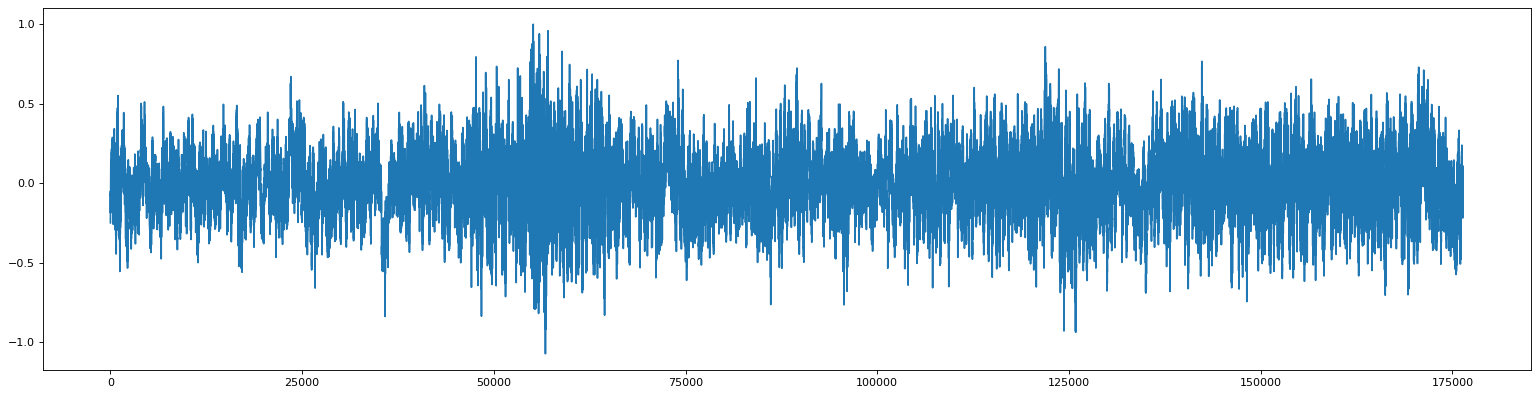

In [99]:
figure(figsize=(24,6), dpi=80)
plt.plot(audio_AA[2])

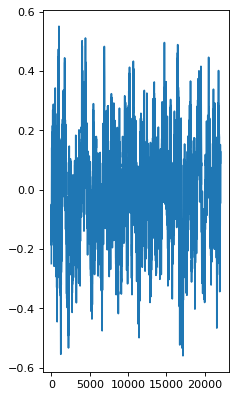

In [98]:
figure(figsize=(3,6), dpi=80)
plt.plot(subAudio_AA[15])

# STOPPED HEREE